## Queries - LSSTCam

In this notebook, we show how to query the LSSTCam repository\
and view the resulting images.\

Craig Lage - 09-Sep-24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from lsst.daf.butler import Butler
from lsst.ip.isr import IsrTask, IsrTaskConfig
from lsst.summit.utils.plotting import plot
import lsst.afw.cameraGeom.utils as camGeomUtils
import lsst.afw.math as afwMath
import lsst.afw.display as afwDisplay

In [2]:
butler = Butler('embargo_new', collections=['LSSTCam/raw/all', 'LSSTCam/calib/unbounded'])

## First, get a list of exposures
### These should match what you see in RubinTV.

In [6]:
dayObs = 20240924
instrument = "LSSTCam"

exposureList = []
for record in butler.registry.queryDimensionRecords("exposure", 
                    where=f"exposure.day_obs={dayObs} and instrument='LSSTCam'"):
    exposureList.append([record.id, record])
exposureList.sort(key=lambda x: x[0])
for [id,record] in exposureList:
    print(record.id, record.observation_type, record.science_program, record.observation_reason, record.exposure_time, record.physical_filter)


2024092400001 bias unknown bias 0.0 ef_43
2024092400002 bias unknown bias 0.0 ef_43
2024092400003 bias unknown bias 0.0 ef_43
2024092400004 bias unknown bias 0.0 ef_43
2024092400005 bias unknown bias 0.0 ef_43
2024092400006 bias unknown bias 0.0 ef_43
2024092400007 bias unknown bias 0.0 ef_43
2024092400008 bias unknown bias 0.0 ef_43
2024092400009 bias unknown bias 0.0 ef_43
2024092400010 bias unknown bias 0.0 ef_43
2024092400011 bias unknown bias 0.0 ef_43
2024092400012 bias unknown bias 0.0 ef_43
2024092400013 bias unknown bias 0.0 ef_43
2024092400014 bias unknown bias 0.0 ef_43
2024092400015 bias unknown bias 0.0 ef_43
2024092400016 bias unknown bias 0.0 ef_43
2024092400017 bias unknown bias 0.0 ef_43
2024092400018 bias unknown bias 0.0 ef_43
2024092400019 bias unknown bias 0.0 ef_43
2024092400020 bias unknown bias 0.0 ef_43
2024092400021 dark unknown dark 900.0 ef_43
2024092400022 dark unknown dark 900.0 ef_43
2024092400030 flat unknown sflat_hi 15.0 ef_43
2024092400031 flat unknow

# Get the data from the headers

In [7]:
expId = 2024092400065
detector = 1
instrument = 'LSSTCam'
mData = butler.get('raw.metadata', detector=detector, exposure=expId, instrument=instrument)
for key in mData.keys():
    print(key, mData[key])

SIMPLE True
EXTEND True
BINX 1
BINY 1
CCDGAIN 1.0
CCDNOISE 10.0
DETSIZE [1:4072,1:4000]
DATE 2024-09-24T22:39:27.263
MJD 60577.94406554382
IMGTYPE FLAT
DATE-OBS 2024-09-24T22:39:12.170
MJD-OBS 60577.94389085658
DATE-TRG 2024-09-24T22:39:27.257
MJD-TRG 60577.94406547444
OBSID MC_C_20240924_000065
DATE-BEG 2024-09-24T22:39:12.170
MJD-BEG 60577.94389085658
DATE-END 2024-09-24T22:39:27.266
MJD-END 60577.94406557875
BUNIT adu
TIMESYS TAI
INSTRUME lsstCam
TELESCOP Simonyi Survey Telescope
OBS-LONG None
OBS-LAT None
OBS-ELEV None
OBSGEO-X None
OBSGEO-Y None
OBSGEO-Z None
RA None
DEC None
RASTART None
DECSTART None
RAEND None
DECEND None
ROTPA None
ROTCOORD None
HASTART None
ELSTART None
AZSTART None
AMSTART None
HAEND None
ELEND None
AZEND None
AMEND None
TRACKSYS None
RADESYS None
FOCUSZ None
OBJECT None
VIGNETTE None
VIGN_MIN None
TESTTYPE SFLAT_HI
CAMCODE MC
CONTRLLR C
DAYOBS 20240924
SEQNUM 65
PROGRAM None
REASON None
TSTAND BOT
IMAGETAG 1d88f6053975b6a8
OBSANNOT 
RUNNUM E1074
CCD_MANU IT

# Now get the raw data

## Next, look at the raw data from one of the exposures.
### Because of the large pedestal, we don't see much.  We need to do ISR

In [8]:
#expId = 2024090600007
detector = 93
instrument = 'LSSTCam'
raw = butler.get('raw', detector=detector, exposure=expId, instrument=instrument)


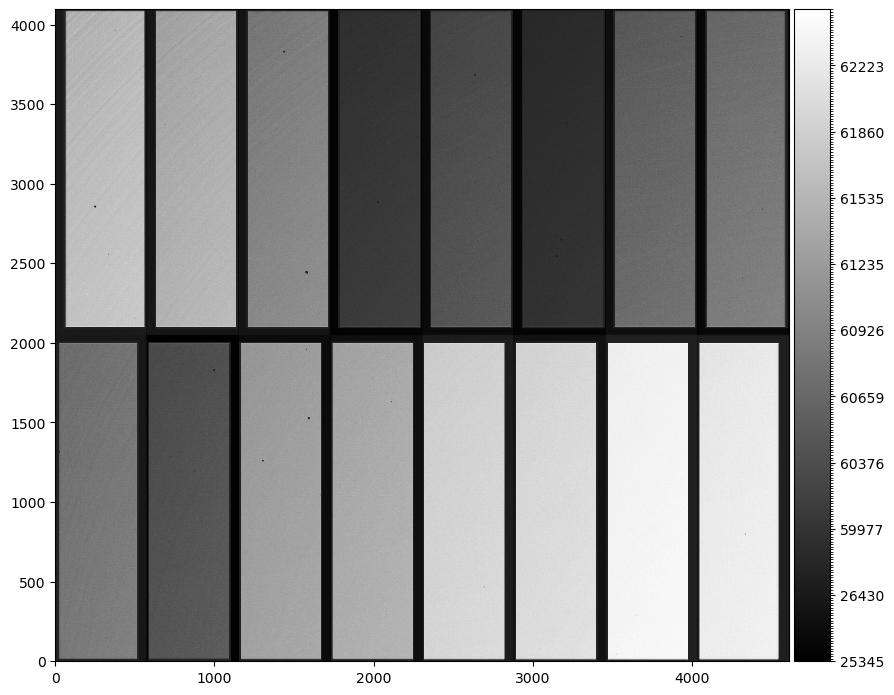

In [9]:
%matplotlib inline        
x = plot(raw, stretch='ccs')
#plt.savefig(f"/home/c/cslage/u/LSSTCam/images/LSSTCam_raw_{detector}_{expId}.png")

## Define a simple ISR
### Just overscan subtraction and bias subtraction.

In [10]:
isrConfig = IsrTaskConfig()
isrConfig.doLinearize=False
isrConfig.doOverscan=True
isrConfig.overscan.fitType="MEDIAN_PER_ROW"
isrConfig.overscan.doParallelOverscan=True
isrConfig.doAssembleCcd=True
isrConfig.doBias=False
isrConfig.doVariance=False
isrConfig.doCrosstalk=False
isrConfig.doBrighterFatter=False
isrConfig.doDark=False
isrConfig.doStrayLight=False
isrConfig.doFlat=False
isrConfig.doFringe=False
isrConfig.doApplyGains=True
isrConfig.usePtcGains=False
isrConfig.doDefect=False
isrConfig.doNanMasking=True
isrConfig.doInterpolate=False
isrConfig.doSaturation=False
isrConfig.doSaturationInterpolation=False
isrTask = IsrTask(config=isrConfig)

## Run the ISR and look at the result

In [11]:
#expId = 2024090600117
#detector = 111
instrument = 'LSSTCam'
exp = butler.get('raw', detector=detector, exposure=expId, instrument=instrument)
isrResult = isrTask.run(exp) # This runs the ISR

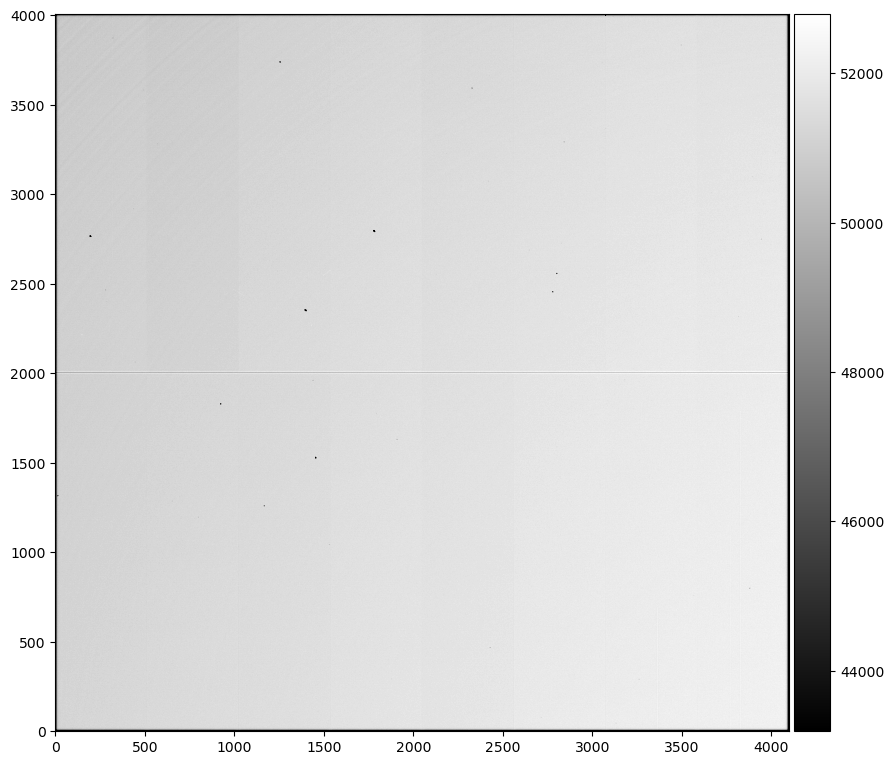

In [12]:
%matplotlib inline
x = plot(isrResult.exposure, stretch='linear')
#plt.savefig(f"/home/c/cslage/u/LSSTCam/images/LSSTCam_{detector}_{expId}.png")

# Plot a small region

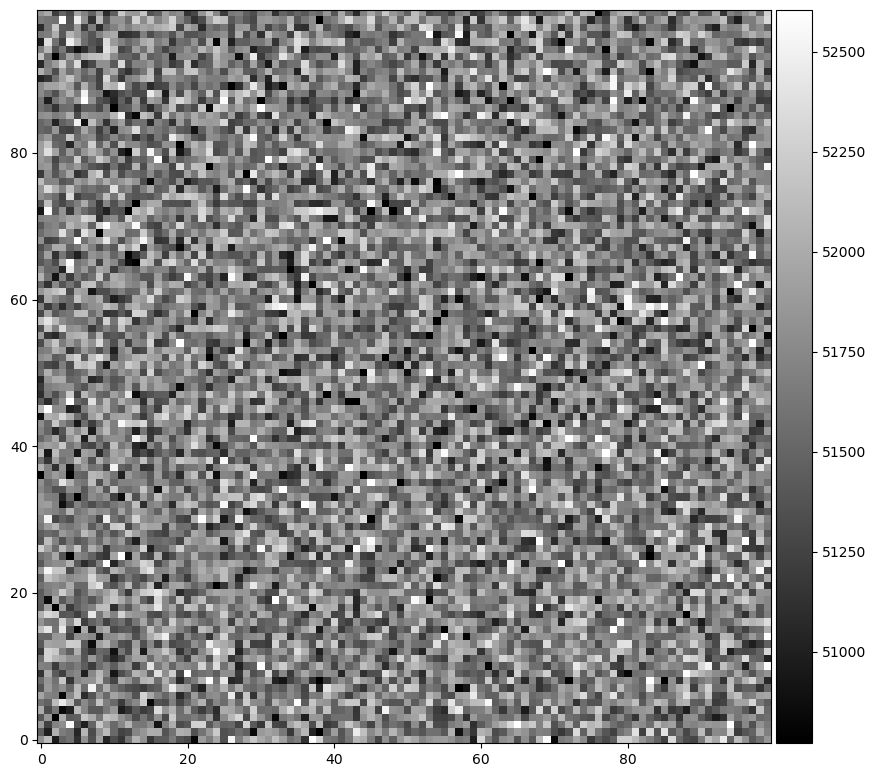

In [13]:
x = plot(isrResult.exposure.image.array[2200:2300, 2600:2700])

# Get the value of a particular pixel

In [14]:
exp.image.array[2100, 2100]

34279.73

# Plot the cross-chip uniformity

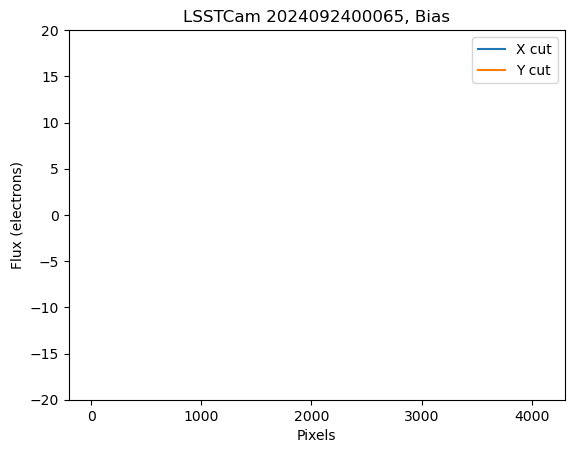

In [15]:
plt.title(f"LSSTCam {expId}, Bias")
plt.plot(isrResult.exposure.image.array[2100, :], label='X cut')
plt.plot(isrResult.exposure.image.array[:, 2100], label='Y cut')
plt.ylim(-20, 20)
plt.ylabel("Flux (electrons)")
plt.xlabel("Pixels")
plt.legend()
#plt.savefig(f"/home/c/cslage/u/LSSTCam/images/LSSTCam_Slices_{detector}_{expId}.png")

# Now assemble all CCDs and plot the result

In [16]:
def myCallback(im, ccd, imageSource):
    """Assemble the CCD image and do basic ISR"""
    dayObs = imageSource.kwargs['day_obs']
    seqNum = imageSource.kwargs['seq_num']
    exp = imageSource.butler.get('raw', detector=ccd.getId(), day_obs=dayObs, seq_num=seqNum)
    isrResult = isrTask.run(exp)
    nQuarter = ccd.getOrientation().getNQuarter()
    oim = afwMath.rotateImageBy90(isrResult.exposure.image, nQuarter)
    return oim

def rawCallback(im, ccd, imageSource):
    """Assemble the CCD image.  Just bias subtraction and gain correction"""
    oim = camGeomUtils.rawCallback(im, ccd, imageSource,
                                   subtractBias=False, correctGain=False)
    return oim

In [ ]:
%matplotlib inline
instrument = "LSSTCam"
camera = butler.get('camera', instrument=instrument)
fig = plt.figure(figsize=(12,12))
import lsst.afw.display as afwDisplay
disp = afwDisplay.Display(1, "matplotlib")
disp.scale('linear', min='zscale')
dayObs = 20240924
seqNum = 65
dataType='raw'
mos = camGeomUtils.showCamera(camera,
                              camGeomUtils.ButlerImage(butler, dataType, 
                                                       instrument=instrument, 
                                                       day_obs=dayObs, seq_num=seqNum,
                                                       verbose=False, callback=myCallback,
                                                       background=np.nan),
                              binSize=16, display=disp, overlay=False,
                              title="%d %d" % (dayObs, seqNum))

#plt.savefig(f"/home/c/cslage/u/LSSTCam/images/LSSTCam_Test_16_{dayObs}_{seqNum}.png")

# Plot the cross-detector uniformity

In [ ]:
%matplotlib inline
plt.title(f"LSSTCam {dayObs}_{seqNum}")
plt.plot(mos.array[2000, :], label="X slice")
plt.plot(mos.array[:, 2000], label="Y slice")
#plt.ylim(-5, 5)
plt.ylabel("Flux (ADU)")
plt.xlabel("Pixels (binned by 16)")
plt.legend()
#plt.savefig(f"/home/c/cslage/u/LSSTCam/images/LSST_Slices_{dayObs}_{seqNum}.png")